In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib  widget

Read in unfiltered, unwrapped igrams. Can take a few minutes.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger area
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
# driver=gdal.GetDriverByName('ISCE')
# unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
# # loop through the dates 
# for i in range(numIgrams): # numIgrams if doing all of them at once
#     date1=dates[i]
#     date2=dates[i+1]
#     igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
#     ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
#     unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
# print('unfiltered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.


Calculate complex coherence for each pixel for each interferogram and save them in folder: /data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/

In [3]:
# calculate coherence using standard method for the point at every time

# loop through all the igrams and calculate coherence for every pixel for each one.
#coh = np.zeros((np.shape(unwr_full_res)),dtype='complex')
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
# bounding box within full area
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000

# area we want to average over to get coherence, same as filtering window 
alooks=4; rlooks=20 # x is range, y is azimuth 

# larger box with western mtns
x1 = 18000 - int(rlooks/2) # because this is the edge of the SLC, I can't get coherence at the western edge pix
y1 = 2100

# output igram size (smaller area at tip of LS)
dx2 = int(np.abs(x1-x2)); dy2 = int(np.abs(y1-y2))
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

# set the folder to save these coh files to 
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'

# loop through the dates 
for i in np.arange(2,numIgrams,1): # numIgrams if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+1]
    # Read in 2 full SLCs to make interferogram 
    ds = gdal.Open(datesDir+"SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    # have to load in more than just the pixels of interest to calculate coh at edge pixels 
    slc1 = ds.GetRasterBand(1).ReadAsArray(int(x2-rlooks/2),int(y2-alooks/2),int(dx2+rlooks),int(dy2+alooks))
    ds = gdal.Open(datesDir+"SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(int(x2-rlooks/2),int(y2-alooks/2),int(dx2+rlooks),int(dy2+alooks))
    aa = slc1*np.conj(slc1)
    bb = slc2*np.conj(slc2)
    ab = slc1*np.conj(slc2)                                              
    for y in np.arange(0,dy2,1): # started with this: np.arange(y2,y1,1)
        for x in np.arange(0,dx2,1): # started with this: np.arange(x2,x1,1)
            # calculate coherence using this formula: <ab*>/sqrt(<aa*><bb*>)
            # aa = np.mean(aa,axis=(0,1)); bb = np.mean(bb,axis=(0,1)); ab = np.mean(ab,axis=(0,1))# this is averaging over axes 0 and 1
            aa_temp = (np.mean(aa[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            bb_temp = (np.mean(bb[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            ab_temp = (np.mean(ab[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            #coh[i,y,x] = ab_temp/np.sqrt(aa_temp*bb_temp) 
            coh[i,y,x] = np.abs(ab_temp/np.sqrt(aa_temp*bb_temp))
    # interpolate the edge pixels 
    temp = coh[i,:,dx2-1]
    for d in np.arange(dx2,dx2+int(rlooks/2),1):
        #print('interpolating edge, column: '+str(d))
        coh[i,:,d] = temp
    print('interpolated edge.')
    # save the coherence plot so I can load it in easily to invert 
    save_file_name = 'coh_'+str(date1)+'-'+str(date2)+'.r4'
    colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(coh[i])
    colds=None
    print('coh for igram '+str(i)+' done and saved.')
#print('coherence calculated for every igram for every pixel.')

interpolated edge.
coh for igram 2 done and saved.
interpolated edge.
coh for igram 3 done and saved.
interpolated edge.
coh for igram 4 done and saved.
interpolated edge.
coh for igram 5 done and saved.
interpolated edge.
coh for igram 6 done and saved.
interpolated edge.
coh for igram 7 done and saved.
interpolated edge.
coh for igram 8 done and saved.
interpolated edge.
coh for igram 9 done and saved.
interpolated edge.
coh for igram 10 done and saved.
interpolated edge.
coh for igram 11 done and saved.
interpolated edge.
coh for igram 12 done and saved.
interpolated edge.
coh for igram 13 done and saved.
interpolated edge.
coh for igram 14 done and saved.
interpolated edge.
coh for igram 15 done and saved.
interpolated edge.
coh for igram 16 done and saved.
interpolated edge.
coh for igram 17 done and saved.
interpolated edge.
coh for igram 18 done and saved.
interpolated edge.
coh for igram 19 done and saved.
interpolated edge.
coh for igram 20 done and saved.
interpolated edge.
c

Try plotting one to make sure my interpolation worked. 

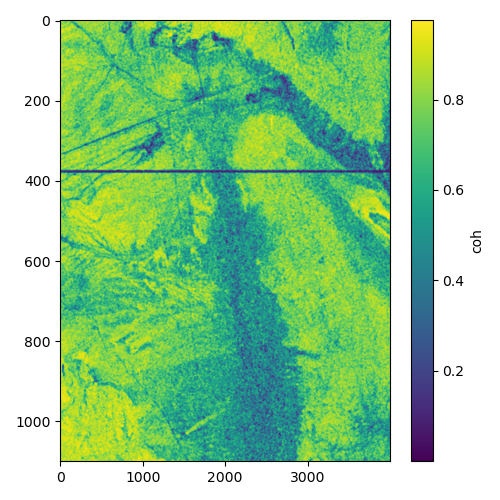

In [20]:
i=0
plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(np.fliplr(coh[i]),aspect='auto'); plt.colorbar(label='coh')
plt.show()

NOW DO SKIP1 coh files. 

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger area
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-2 # SKIP1
# set the driver first, only do once.
# driver=gdal.GetDriverByName('ISCE')
# unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
# # loop through the dates 
# for i in range(numIgrams): # numIgrams if doing all of them at once
#     date1=dates[i]
#     date2=dates[i+2] # SKIP1
#     igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
#     ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
#     unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
# print('unfiltered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.


In [4]:
# calculate coherence using standard method for the point at every time

# loop through all the igrams and calculate coherence for every pixel for each one.
#coh = np.zeros((np.shape(unwr_full_res)),dtype='complex')
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
# bounding box within full area
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000

# area we want to average over to get coherence, same as filtering window 
alooks=4; rlooks=20 # x is range, y is azimuth 

# larger box with western mtns
x1 = 18000 - int(rlooks/2) # because this is the edge of the SLC, I can't get coherence at the western edge pix
y1 = 2100

# output igram size (smaller area at tip of LS)
dx2 = int(np.abs(x1-x2)); dy2 = int(np.abs(y1-y2))
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

# set the folder to save these coh files to 
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'

# loop through the dates 
for i in np.arange(1,numIgrams,1): # numIgrams if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+2]
    # Read in 2 full SLCs to make interferogram 
    ds = gdal.Open(datesDir+"SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    # have to load in more than just the pixels of interest to calculate coh at edge pixels 
    slc1 = ds.GetRasterBand(1).ReadAsArray(int(x2-rlooks/2),int(y2-alooks/2),int(dx2+rlooks),int(dy2+alooks))
    ds = gdal.Open(datesDir+"SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(int(x2-rlooks/2),int(y2-alooks/2),int(dx2+rlooks),int(dy2+alooks))
    aa = slc1*np.conj(slc1)
    bb = slc2*np.conj(slc2)
    ab = slc1*np.conj(slc2)
    for y in np.arange(0,dy2,1): # started with this: np.arange(y2,y1,1)
        for x in np.arange(0,dx2,1): # started with this: np.arange(x2,x1,1)
            # calculate coherence using this formula: <ab*>/sqrt(<aa*><bb*>)
            # aa = np.mean(aa,axis=(0,1)); bb = np.mean(bb,axis=(0,1)); ab = np.mean(ab,axis=(0,1))# this is averaging over axes 0 and 1
            aa_temp = (np.mean(aa[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            bb_temp = (np.mean(bb[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            ab_temp = (np.mean(ab[int(y):int(y+alooks),int(x):int(x+rlooks)]))
            #coh[i,y,x] = ab_temp/np.sqrt(aa_temp*bb_temp) 
            coh[i,y,x] = np.abs(ab_temp/np.sqrt(aa_temp*bb_temp))
    # interpolate the edge pixels 
    temp = coh[i,:,dx2-1]
    #print(np.shape(temp))
    for d in np.arange(dx2,dx2+int(rlooks/2),1):
        #print('interpolating edge, column: '+str(d))
        coh[i,:,d] = temp
        
    # save the coherence plot so I can load it in easily to invert 
    save_file_name = 'coh_'+str(date1)+'-'+str(date2)+'.r4'
    colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(coh[i])
    colds=None
    print('coh for igram '+str(i)+' done and saved.')
#print('coherence calculated for every igram for every pixel.')

coh for igram 1 done and saved.
coh for igram 2 done and saved.
coh for igram 3 done and saved.
coh for igram 4 done and saved.
coh for igram 5 done and saved.
coh for igram 6 done and saved.
coh for igram 7 done and saved.
coh for igram 8 done and saved.
coh for igram 9 done and saved.
coh for igram 10 done and saved.
coh for igram 11 done and saved.
coh for igram 12 done and saved.
coh for igram 13 done and saved.
coh for igram 14 done and saved.
coh for igram 15 done and saved.
coh for igram 16 done and saved.
coh for igram 17 done and saved.
coh for igram 18 done and saved.
coh for igram 19 done and saved.
coh for igram 20 done and saved.
coh for igram 21 done and saved.
coh for igram 22 done and saved.
coh for igram 23 done and saved.
coh for igram 24 done and saved.
coh for igram 25 done and saved.
coh for igram 26 done and saved.
coh for igram 27 done and saved.
coh for igram 28 done and saved.
coh for igram 29 done and saved.
coh for igram 30 done and saved.
coh for igram 31 do